In [16]:
#imports
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm 

In [2]:
# calculate normalized return
def normalized_return(mean, std, ret):
    return (ret - mean) / std

In [3]:
# calculates the P(|return|>x)
def distribution_function(normalized_abs_returns, x):
    normalized_abs_returns_len = len(normalized_abs_returns)
    points_greater_than_x = np.sum(normalized_abs_returns > x)
    prob = points_greater_than_x / normalized_abs_returns_len
    
    return prob

In [4]:
# get the (X, P(|r|>0)) -pairs
def get_probability_distribution_x_pairs(normalized_abs_returns, x_range):
    probability_distribution_x_pairs = []

    for x in x_range:    
        prob = distribution_function(normalized_abs_returns, x)
        if prob > 0:
            probability_distribution_x_pairs.append((x, prob))
        else:
            break
    return probability_distribution_x_pairs

## Load S&P500 index from Yahoo
## Date range: 1-1-1980 to 1-9-2020
## Data points: 10256

In [5]:
start = datetime.datetime(1980, 1, 1)
end = datetime.datetime(2020, 9, 1)

sp500 = web.DataReader("^GSPC", 'yahoo', start, end) # S&P 500 index
rows, cols = sp500.shape
print('Total rows:', rows)
sp500.head()

Total rows: 10256


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1980-01-02,108.430000,105.290001,107.940002,105.760002,40610000,105.760002
1980-01-03,106.080002,103.260002,105.760002,105.220001,50480000,105.220001
1980-01-04,107.080002,105.089996,105.220001,106.519997,39130000,106.519997
1980-01-07,107.800003,105.800003,106.519997,106.809998,44500000,106.809998
1980-01-08,109.290001,106.290001,106.809998,108.949997,53390000,108.949997


## Calculate daily returns $$ (Adj Close - Open) / Open * 100 $$
## Calculate normalized daily returns
## $$ r^{'}_t = (r_{it} - r_i)/\delta_{r,i} $$ where $r_i$ is the mean of the $r_{it}$, and $\sigma_{r,i}$ is their standard deviation.
## Normalized returns have standard deviation of 1 and mean of 0 (or close to zero)
## Also, calculate the absolute value of normalized returns.
## Max normalized return is 19.1, this is also the max std
### (Gabaix, 2009)

In [6]:
sp500['daily_return'] = (sp500['Adj Close'] - sp500['Open']) / sp500['Open'] * 100
# max daily return 10.7%, min daily return -20.4%

mean_of_returns = sp500['daily_return'].mean() 
std_of_returns = sp500['daily_return'].std()

sp500['normalized_return'] = normalized_return(mean_of_returns, std_of_returns, sp500['daily_return'])
sp500['normalized_return_abs'] = sp500['normalized_return'].abs()

print('mean of returns:', mean_of_returns)
print('std of returns', std_of_returns)
print('max normalized return abs', sp500['normalized_return_abs'].max())

sp500.tail()

mean of returns: 0.03716324210326685
std of returns 1.0719062404165836
max normalized return abs 19.128626430823807


,High,Low,Open,Close,Volume,Adj Close,daily_return,normalized_return,normalized_return_abs
Date,,,,,,,,,
2020-08-26,3481.070068,3444.149902,3449.969971,3478.729980,3754360000,3478.729980,0.833631,0.743038,0.743038
2020-08-27,3501.379883,3468.350098,3485.139893,3484.550049,3929560000,3484.550049,-0.016925,-0.050459,0.050459
2020-08-28,3509.229980,3484.320068,3494.689941,3508.010010,3855880000,3508.010010,0.381152,0.320913,0.320913
2020-08-31,3514.770020,3493.250000,3509.729980,3500.310059,4342290000,3500.310059,-0.268394,-0.285060,0.285060
2020-09-01,3528.030029,3494.600098,3507.439941,3526.649902,4083110000,3526.649902,0.547692,0.476281,0.476281


## This chart shows that there can be a lot of variance in the daily returns. Especially in 19-10-1987 the daily return was -20.47%

Date                     1987-10-19 00:00:00
High                                   282.7
Low                                   224.83
Open                                   282.7
Close                                 224.84
Volume                             604300000
Adj Close                             224.84
daily_return                        -20.4669
normalized_return                   -19.1286
normalized_return_abs                19.1286
Name: 1971, dtype: object


Text(0, 0.5, '|normalized daily return|')

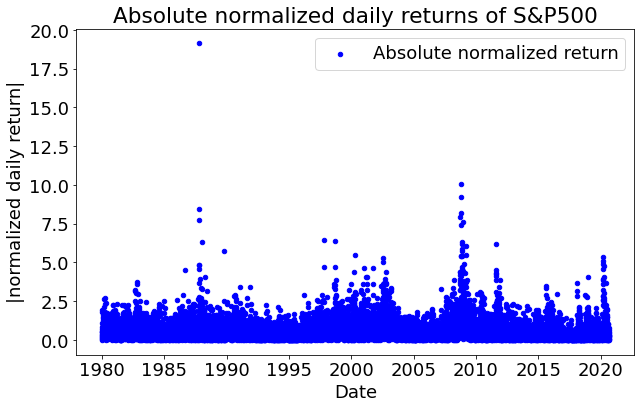

In [15]:
df = sp500.reset_index()
dates = df['Date']
returns = df['normalized_return_abs']

print(df.loc[returns.idxmax()])

matplotlib.rcParams.update({'font.size': 18})
fig, axe = plt.subplots(figsize=(10, 6))
plt.scatter(dates, returns, s=20, color='blue', label='Absolute normalized return')
plt.legend(loc=1)
plt.title('Absolute normalized daily returns of S&P500')
plt.xlabel('Date')
plt.ylabel('|normalized daily return|')

## Calculate $ P(|return|>0) $, $ x $ pairs
## Create two sets of data, ignore x's which result to probability of 0:
## 1. Use the x range of 0.01 .. 20. Result is used in plots below.
## 2. Use x range of 2..20 to examine the tails (max std is 19.1). The x range is same as Gabaix (2009) uses to examine the large standard deviations of returns. This is used later for OLS and last figure.

In [8]:
normalized_abs_returns = np.array(sp500['normalized_return_abs'])
x_range = np.arange(2, 20, 0.01)
probability_distribution_x_pairs = get_probability_distribution_x_pairs(normalized_abs_returns, x_range)

In [9]:
normalized_abs_returns = np.array(sp500['normalized_return_abs'])
x_range = np.arange(0.01, 20, 0.01)
probability_distribution_x_pairs_larger_range = get_probability_distribution_x_pairs(normalized_abs_returns, x_range)

## Plot the results

Text(0, 0.5, 'P(|return|>0)')

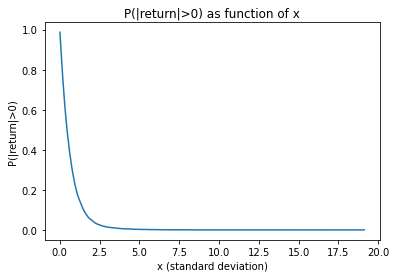

In [10]:
plt.plot(*zip(*probability_distribution_x_pairs_larger_range))
plt.title('P(|return|>0) as function of x')
plt.xlabel('x (standard deviation)')
plt.ylabel('P(|return|>0)')

## Same as above but plotted using log axes, which results to (somewhat) straight line
### on the bottom-right corner there's a horizontal line,  perhaps it would even out with bigger dataset OR my probability distribution funcion is wrong

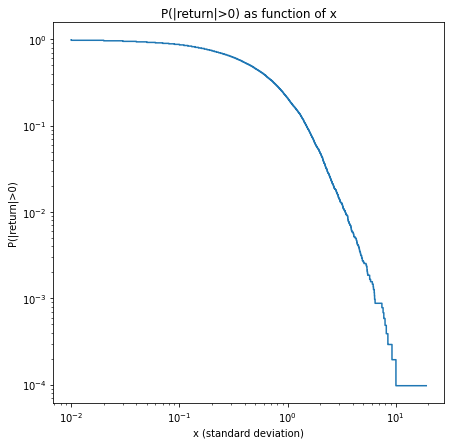

In [11]:
f, ax = plt.subplots(figsize=(7, 7))
plt.step(*zip(*probability_distribution_x_pairs_larger_range))
plt.title('P(|return|>0) as function of x')
plt.xlabel('x (standard deviation)')
plt.ylabel('P(|return|>0)')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Ordinary Least Squares regression
### get the ln of x and probability distributions and use those in model

In [12]:
df = pd.DataFrame(data=probability_distribution_x_pairs, columns=["x", "prob"])
X = np.array(df['x'])
Y = np.array(df['prob'])
X_log = np.log(X)
Y_log = np.log(Y)
X_log = sm.add_constant(X_log) 
result = sm.OLS(Y_log, X_log).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 2.614e+04
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:31:35   Log-Likelihood:                -1045.1
No. Observations:                1713   AIC:                             2094.
Df Residuals:                    1711   BIC:                             2105.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2176      0.043    -28.626      0.0

## Power law function:
## $Y = aX^\beta$, where $Y$ and $X$ are variables of interest, $\beta$ is called the power law exponent, and $a$ is typically an unremarkable constant  
## $ P(|r|>X) = aX^\beta  $
## $ ln(P(|r|>X) = ln(a) + \beta * ln(X) $ <br/>
## From the OLS regression results: $ ln(a) = -1.2176 $, $ \beta = -3.0049 $
## $ ln(P(|r|>X) = -1.2176 -3.0049 * ln(X) $
## $ e^{ln(P(|r|>X)} = e^{-1.2716-3.0049*ln(x)} $
## $ P(|r|>X) = 0.2959 * X^{-3.0049} $ <br/>

## Gopikrishnan et al. (1999) found that the distribution function of returns for the 1000 largest U.S. stocks and several major international indices is:
## $ P(|r_t| > x) = \frac{a}{x^\zeta} $
## with ζ = 3, the so-called “cubic” law of stock market returns

## (Gabaix 2003, 2009, 2016) find the same: $\zeta$ is close to 3 with the formulas they use below:
## $ P(|r_t|) \sim X^{-\zeta}  $
## $ P(|r_t|) \sim kX^{-\zeta}  $

## Create a trend line

In [13]:
#df = pd.DataFrame(data=probability_distribution_x_pairs, columns=["x", "prob"])
prob_hat = (df['x'] ** (-3.0049)) * 0.2959
df.insert(loc=1, value=prob_hat, column='prob_hat')
df.head(4)

,x,prob_hat,prob
0,2.00,0.036862,0.048459
1,2.01,0.036314,0.048167
2,2.02,0.035776,0.047484
3,2.03,0.035249,0.046997


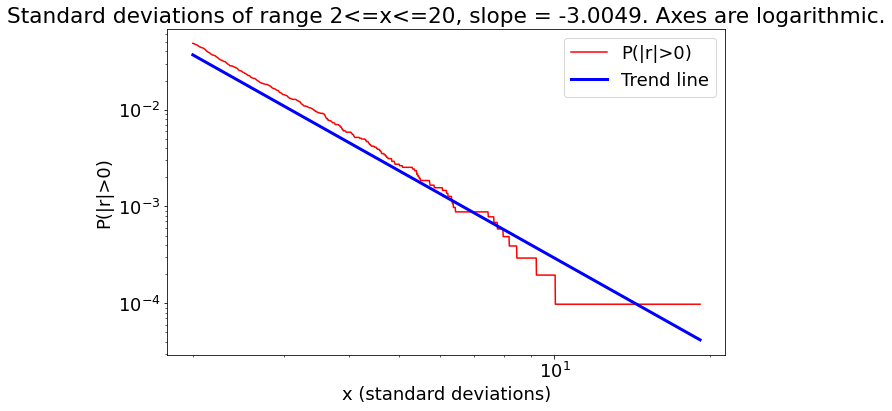

In [14]:
matplotlib.rcParams.update({'font.size': 18})
fig, axe = plt.subplots(figsize=(10, 6))

#plt.scatter(df['x'], df['prob'], s=50, color='red', label='Prob')
plt.plot(df['x'], df['prob'], color='red', label='P(|r|>0)')
plt.plot(df['x'], df['prob_hat'], lw=3, color='blue', label='Trend line')
plt.legend(loc=1)
plt.title('Standard deviations of range 2<=x<=20, slope = -3.0049. Axes are logarithmic.')
plt.xlabel('x (standard deviations)')
plt.ylabel('P(|r|>0)')
plt.xscale('log')
plt.yscale('log')

## In this sample  $\zeta$ is close to 3, too. This means that returns are distributed with a power law $ P(|r|>x)x^{-\zeta_t} $ for large x between 2 and 20 standard deviations of returns.